### IMPORTS

In [1]:
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
def gaussian_entropy(sigma):
    return 0.5 * q.sigma.shape[0] * (1.0 + torch.log(2*torch.tensor(np.pi))) + torch.sum(torch.log(sigma))

In [5]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
model = nn.Sequential(
                nn.Linear(1, 10),
                nn.Tanh(),
                nn.Linear(10, 20),
                nn.Tanh(),
                nn.Linear(20, 1),
                )

In [7]:
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=1, bias=True)
)

In [8]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [9]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

In [10]:
param_count = get_param(model).shape[0]

In [11]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [12]:
def logprior(x):
    return prior.log_prob(x)

In [13]:
def loglikelihood(theta, model, x, y, sigma_noise):
    set_param(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [14]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [15]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.0001, device=device)
q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 

q.rho.requires_grad = False
q.mu.requires_grad = True

In [58]:
theta = q.sample()

In [59]:
theta

tensor([[ 1.2050e-04,  7.9208e-02, -8.4977e-05,  9.1194e-05, -6.1342e-05,
         -2.9123e-05,  5.1749e-03, -1.4512e-03, -3.4449e-04, -6.8910e-01,
          1.2016e-04, -1.0615e-04,  2.2181e-04, -7.9637e-05, -8.7739e-06,
         -3.4229e-02,  1.4964e-04, -8.7872e-02,  1.9428e-04,  6.4098e-05,
         -6.3019e-05, -1.1021e-04,  5.9306e-05, -1.2236e-02, -2.6770e-05,
          5.6745e-04, -2.4523e-04, -1.4410e-04, -3.6802e-04,  1.7714e-04,
          1.8862e-02, -7.6364e-02,  2.7637e-05,  6.1804e-05,  1.9858e-05,
          9.1319e-02, -1.2965e-03,  1.2030e-02, -1.6995e-01, -8.8457e-05,
          9.6465e-02,  2.7228e-05,  1.5638e-04,  1.0298e-01,  2.3329e-01,
          1.2082e-04,  3.7065e-05,  2.8988e-02,  7.2223e-05,  1.9424e-02,
          3.9656e-02,  1.9942e-02,  4.2244e-01, -1.6611e-05, -5.5483e-05,
          7.1733e-05, -2.1670e-04, -5.6706e-02, -5.7100e-05,  1.0148e-04,
          1.4847e-01,  5.4335e-05,  1.0041e-04, -5.4781e-01, -4.7334e-03,
         -5.7059e-05,  5.7464e-05, -2.

In [64]:
S = [p.shape for p in model.parameters()]
I = [0] + list(np.cumsum([s.numel() for s in S]))

In [79]:
P = [p for p in model.parameters()]

In [80]:
i = 2

In [81]:
torch.nn.Parameter(torch.reshape(theta[0,I[i]:I[i+1]], S[i]))

Parameter containing:
tensor([[-6.3019e-05, -1.1021e-04,  5.9306e-05, -1.2236e-02, -2.6770e-05,
          5.6745e-04, -2.4523e-04, -1.4410e-04, -3.6802e-04,  1.7714e-04],
        [ 1.8862e-02, -7.6364e-02,  2.7637e-05,  6.1804e-05,  1.9858e-05,
          9.1319e-02, -1.2965e-03,  1.2030e-02, -1.6995e-01, -8.8457e-05],
        [ 9.6465e-02,  2.7228e-05,  1.5638e-04,  1.0298e-01,  2.3329e-01,
          1.2082e-04,  3.7065e-05,  2.8988e-02,  7.2223e-05,  1.9424e-02],
        [ 3.9656e-02,  1.9942e-02,  4.2244e-01, -1.6611e-05, -5.5483e-05,
          7.1733e-05, -2.1670e-04, -5.6706e-02, -5.7100e-05,  1.0148e-04],
        [ 1.4847e-01,  5.4335e-05,  1.0041e-04, -5.4781e-01, -4.7334e-03,
         -5.7059e-05,  5.7464e-05, -2.8373e-05,  4.5594e-05,  1.1081e+00],
        [-1.3717e-04,  6.2927e-05,  1.7027e-01, -7.1297e-06,  1.6032e-02,
          3.1911e-01,  4.3348e-05,  2.6459e-04, -5.5264e-02,  5.4599e-02],
        [-4.9978e-03,  2.7210e-01, -7.9206e-06,  1.0292e-01,  6.9527e-05,
         -

In [87]:
P[i]

Parameter containing:
tensor([[-6.3019e-05, -1.1021e-04,  5.9306e-05, -1.2236e-02, -2.6770e-05,
          5.6745e-04, -2.4523e-04, -1.4410e-04, -3.6802e-04,  1.7714e-04],
        [ 1.8862e-02, -7.6364e-02,  2.7637e-05,  6.1804e-05,  1.9858e-05,
          9.1319e-02, -1.2965e-03,  1.2030e-02, -1.6995e-01, -8.8457e-05],
        [ 9.6465e-02,  2.7228e-05,  1.5638e-04,  1.0298e-01,  2.3329e-01,
          1.2082e-04,  3.7065e-05,  2.8988e-02,  7.2223e-05,  1.9424e-02],
        [ 3.9656e-02,  1.9942e-02,  4.2244e-01, -1.6611e-05, -5.5483e-05,
          7.1733e-05, -2.1670e-04, -5.6706e-02, -5.7100e-05,  1.0148e-04],
        [ 1.4847e-01,  5.4335e-05,  1.0041e-04, -5.4781e-01, -4.7334e-03,
         -5.7059e-05,  5.7464e-05, -2.8373e-05,  4.5594e-05,  1.1081e+00],
        [-1.3717e-04,  6.2927e-05,  1.7027e-01, -7.1297e-06,  1.6032e-02,
          3.1911e-01,  4.3348e-05,  2.6459e-04, -5.5264e-02,  5.4599e-02],
        [-4.9978e-03,  2.7210e-01, -7.9206e-06,  1.0292e-01,  6.9527e-05,
         -

In [83]:
model.apply

Parameter containing:
tensor([[ 8.8864e-05,  2.6104e-04,  1.4859e-04, -1.2262e-02, -8.1558e-05,
          6.2325e-04, -3.1478e-04, -1.8654e-04, -4.5879e-05,  5.9376e-05],
        [ 1.8785e-02, -7.6552e-02,  1.4259e-05,  2.0822e-04, -8.2391e-05,
          9.1598e-02, -1.1354e-03,  1.2242e-02, -1.6994e-01, -1.3897e-04],
        [ 9.6589e-02,  1.1475e-04,  2.0821e-05,  1.0300e-01,  2.3326e-01,
          3.6796e-05,  3.1299e-05,  2.9096e-02,  1.1366e-04,  1.9292e-02],
        [ 3.9589e-02,  2.0036e-02,  4.2225e-01,  5.4407e-05,  7.4636e-05,
          7.9495e-05, -1.4665e-05, -5.6916e-02,  6.5493e-05,  1.8050e-04],
        [ 1.4844e-01, -1.2049e-05,  2.8429e-05, -5.4780e-01, -4.5208e-03,
          2.3438e-05, -9.5868e-05,  1.6055e-04,  7.5991e-05,  1.1081e+00],
        [-7.8174e-05, -3.3062e-05,  1.7030e-01,  2.0031e-06,  1.5973e-02,
          3.1884e-01,  9.2476e-05, -4.7512e-05, -5.5452e-02,  5.4750e-02],
        [-5.1302e-03,  2.7218e-01,  9.1690e-05,  1.0265e-01, -1.6494e-05,
          

In [84]:
P[i].set_(torch.reshape(theta[0,I[i]:I[i+1]], S[i]))

Parameter containing:
tensor([[-6.3019e-05, -1.1021e-04,  5.9306e-05, -1.2236e-02, -2.6770e-05,
          5.6745e-04, -2.4523e-04, -1.4410e-04, -3.6802e-04,  1.7714e-04],
        [ 1.8862e-02, -7.6364e-02,  2.7637e-05,  6.1804e-05,  1.9858e-05,
          9.1319e-02, -1.2965e-03,  1.2030e-02, -1.6995e-01, -8.8457e-05],
        [ 9.6465e-02,  2.7228e-05,  1.5638e-04,  1.0298e-01,  2.3329e-01,
          1.2082e-04,  3.7065e-05,  2.8988e-02,  7.2223e-05,  1.9424e-02],
        [ 3.9656e-02,  1.9942e-02,  4.2244e-01, -1.6611e-05, -5.5483e-05,
          7.1733e-05, -2.1670e-04, -5.6706e-02, -5.7100e-05,  1.0148e-04],
        [ 1.4847e-01,  5.4335e-05,  1.0041e-04, -5.4781e-01, -4.7334e-03,
         -5.7059e-05,  5.7464e-05, -2.8373e-05,  4.5594e-05,  1.1081e+00],
        [-1.3717e-04,  6.2927e-05,  1.7027e-01, -7.1297e-06,  1.6032e-02,
          3.1911e-01,  4.3348e-05,  2.6459e-04, -5.5264e-02,  5.4599e-02],
        [-4.9978e-03,  2.7210e-01, -7.9206e-06,  1.0292e-01,  6.9527e-05,
         -

In [16]:
n_samples_ELBO = 10
    
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

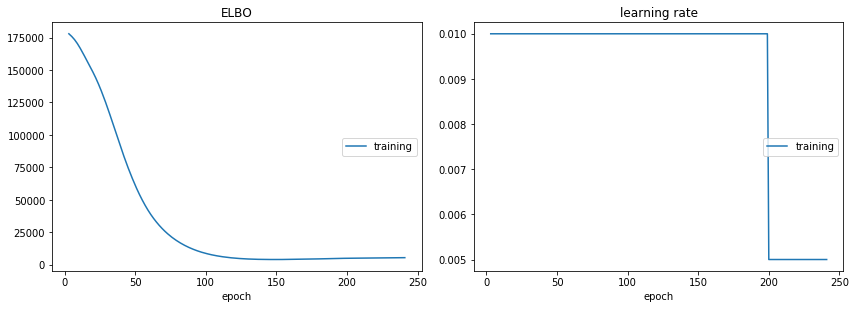

ELBO:
training   (min: 4053.943, max: 179587.094, cur: 5479.330)

learning rate:
training   (min:    0.005, max:    0.010, cur:    0.005)


KeyboardInterrupt: 

In [17]:
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    listDIV = []
    for i in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        listDIV.append((LQ - LP))

    L = torch.stack(listDIV).mean()

    #with torch.no_grad():
    #    LL = predictive_loglikelihood(z).mean().detach().clone()

    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()

    if learning_rate < 0.00001:
        break

In [18]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

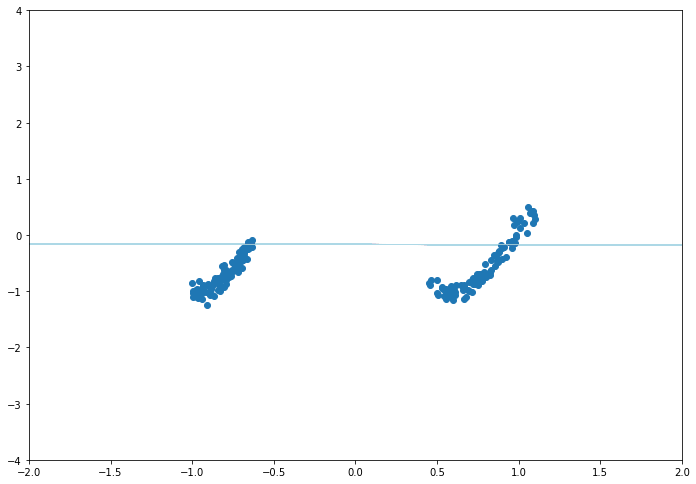

In [19]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = q.sample()
    set_param(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = prior.sample()
    set_param(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')